In [1]:
import pandas as pd
import numpy as np
from sklearn import ensemble
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import seaborn as sns
from matplotlib import pyplot as plt
from pathlib import Path
from matplotlib import style

style.use("ggplot")

In [2]:
path = Path.home() / 'PycharmProjects/data_toolkit/stats/data'
transactions = pd.read_csv(path / 'customer_transactions.csv')
print(transactions.shape)
transactions.head()

(10000, 32)


,customer_id,cacq,day_0,day_1,day_2,day_3,day_4,day_5,day_6,day_7,...,day_20,day_21,day_22,day_23,day_24,day_25,day_26,day_27,day_28,day_29
0,0,-110,6,0,73,10,0,0,0,21,...,0,0,0,0,0,0,0,0,0,0
1,1,-58,0,0,0,15,0,3,2,0,...,0,0,0,0,0,0,0,0,0,0
2,2,-7,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,3,-30,0,3,2,0,9,0,0,0,...,0,0,40,0,0,0,0,0,0,0
4,4,-42,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
profitable = (transactions[['customer_id']].assign(net_value=transactions.drop(columns='customer_id').sum(axis=1)))
customer_features = (pd.read_csv(path / 'customer_features.csv').merge(profitable, on='customer_id'))
customer_features.head()

,customer_id,region,income,age,net_value
0,0,30,1025,24,130
1,1,41,1649,26,10
2,2,18,2034,33,-6
3,3,20,1859,35,136
4,4,1,1243,26,-8


In [4]:
train, test = train_test_split(customer_features, test_size=0.3, random_state=13)
train.shape, test.shape

((7000, 5), (3000, 5))

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 [Text(0, 0, '(499.999, 601.95]'),
  Text(1, 0, '(601.95, 719.0]'),
  Text(2, 0, '(719.0, 834.0]'),
  Text(3, 0, '(834.0, 958.0]'),
  Text(4, 0, '(958.0, 1082.5]'),
  Text(5, 0, '(1082.5, 1241.7]'),
  Text(6, 0, '(1241.7, 1389.0]'),
  Text(7, 0, '(1389.0, 1565.0]'),
  Text(8, 0, '(1565.0, 1737.0]'),
  Text(9, 0, '(1737.0, 1922.0]'),
  Text(10, 0, '(1922.0, 2128.0]'),
  Text(11, 0, '(2128.0, 2377.4]'),
  Text(12, 0, '(2377.4, 2636.0]'),
  Text(13, 0, '(2636.0, 2946.6]'),
  Text(14, 0, '(2946.6, 3324.0]'),
  Text(15, 0, '(3324.0, 3782.2]'),
  Text(16, 0, '(3782.2, 4376.0]'),
  Text(17, 0, '(4376.0, 5104.1]'),
  Text(18, 0, '(5104.1, 6459.0]'),
  Text(19, 0, '(6459.0, 21289.0]')])

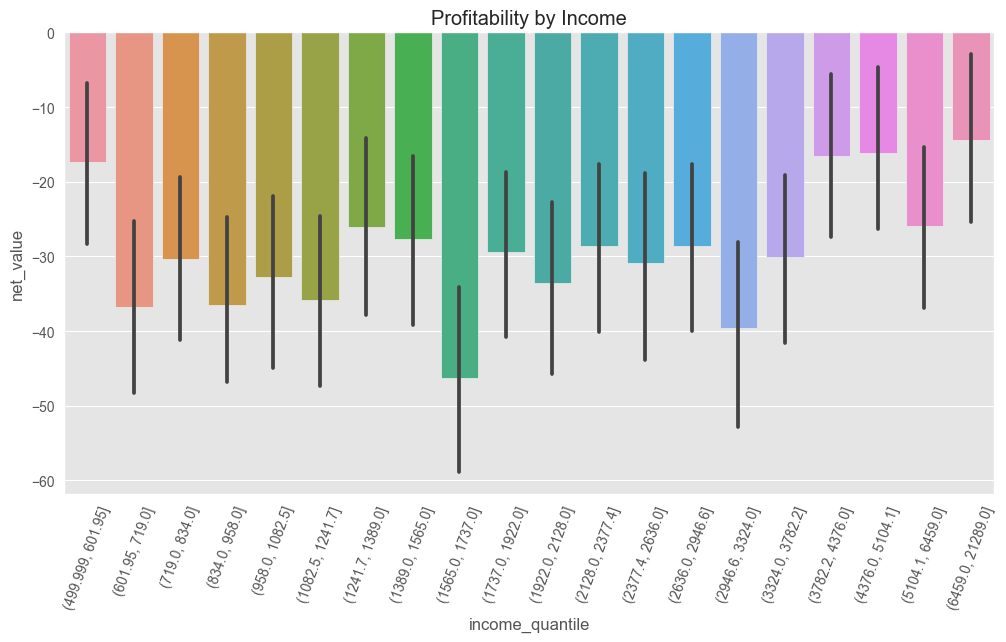

In [5]:
plt.figure(figsize=(12,6))
np.random.seed(123)
sns.barplot(data=train.assign(income_quantile=pd.qcut(train["income"], q=20)), x="income_quantile", y="net_value")
plt.title("Profitability by Income")
plt.xticks(rotation=70)

Text(0.5, 1.0, 'Profitability by Region')

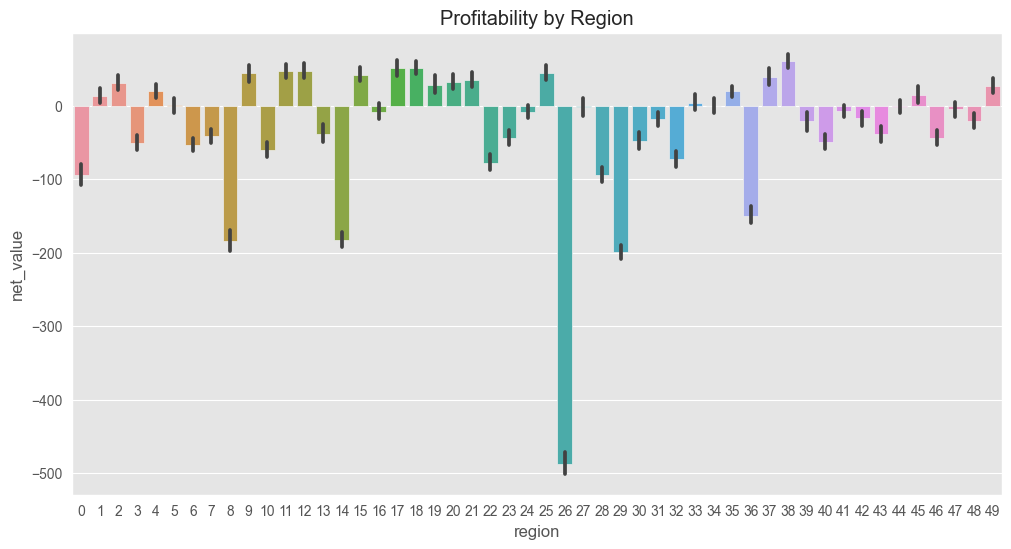

In [6]:
plt.figure(figsize=(12,6))
np.random.seed(123)
region_plot = sns.barplot(data=train, x="region", y="net_value")
plt.title("Profitability by Region")

In [7]:
# extract the lower bound of the 95% CI from the plot above
regions_to_net = train.groupby('region')['net_value'].agg(['mean', 'count', 'std'])
regions_to_net = regions_to_net.assign(lower_bound=regions_to_net['mean'] - 1.96 * regions_to_net['std'] / (regions_to_net['count'] ** 0.5))
regions_to_net_lower_bound = regions_to_net['lower_bound'].to_dict()
regions_to_net = regions_to_net['mean'].to_dict()

# filters regions where the net value lower bound is > 0.
regions_to_invest = {region: net for region, net in regions_to_net_lower_bound.items() if net > 0}
regions_to_invest

{1: 2.9729729729729737,
 2: 20.543302704837856,
 4: 10.051075065003388,
 9: 32.08862469914759,
 11: 37.434210420891255,
 12: 37.44213667009523,
 15: 32.09847683044394,
 17: 39.52753893574483,
 18: 41.86162250217046,
 19: 15.62406327716401,
 20: 22.06654814414531,
 21: 24.621030401718578,
 25: 33.97022928360584,
 35: 11.68776141117673,
 37: 27.83183541449011,
 38: 49.740709395699994,
 45: 2.286387928016998,
 49: 17.01853709535029}

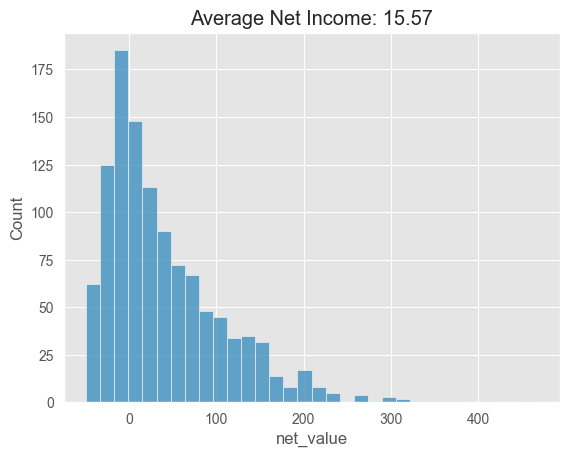

In [8]:
region_policy = (test[test["region"].isin(regions_to_invest.keys())])
sns.histplot(data=region_policy, x="net_value")

# average has to be over all customers, not just the one we've filtered with the policy
plt.title("Average Net Income: %.2f" % (region_policy["net_value"].sum() / test.shape[0]));

## Machine Learning Models as Policy Inputs

The goal of this model will be to predict `net_value` using `region`, `income`, `age`. To help it, we will take the `region` feature, which is categorical, and encode it with a numerical value. We will replace each region by the region's average net value on the training set.

In [9]:
def encode(df):
    return df.replace({"region": regions_to_net})

model_params = {'n_estimators': 400, 'max_depth': 4, 'min_samples_split': 10, 'learning_rate': 0.01, 'loss': 'ls'}
features = ["region", "income", "age"]
target = "net_value"
reg = ensemble.GradientBoostingRegressor(**model_params)

# fit model on the training set
encoded_train = train[features].pipe(encode)
reg.fit(encoded_train, train[target])

C:\Users\Kevin\miniconda3\envs\hihi\lib\site-packages\sklearn\ensemble\_gb.py:294: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
  warnings.warn(


GradientBoostingRegressor(learning_rate=0.01, loss='ls', max_depth=4,
                          min_samples_split=10, n_estimators=400)

Here, I'll use one which is called R2. We don't need to get into much detail here. It suffices to say that the R2 is used to evaluate models that predict a continuous variable (like net_income). Also, R2 can go from minus infinity (it will be negative if the prediction is worse than the average) to 1.0. The R2 tells us how much of the variance in `net_income` is explained by our model.

In [10]:
train_pred = (encoded_train.assign(predictions=reg.predict(encoded_train[features])))

print("Train R2: ", r2_score(y_true=train[target], y_pred=train_pred["predictions"]))
print("Test R2: ", r2_score(y_true=test[target], y_pred=reg.predict(test[features].pipe(encode))))

Train R2:  0.7108790300152951
Test R2:  0.6938513063048141


In [11]:
model_policy = test.assign(prediction=reg.predict(test[features].pipe(encode)))
model_policy.head()

,customer_id,region,income,age,net_value,prediction
5952,5952,19,1983,23,21,47.734883
1783,1783,31,914,31,-46,-36.026935
4811,4811,33,1349,25,-19,22.553420
145,145,20,1840,26,55,48.306256
7146,7146,19,3032,34,-17,7.039414


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
 [Text(0, 0, '(-530.458, -450.056]'),
  Text(1, 0, '(-450.056, -194.117]'),
  Text(2, 0, '(-194.117, -179.563]'),
  Text(3, 0, '(-179.563, -164.328]'),
  Text(4, 0, '(-164.328, -111.039]'),
  Text(5, 0, '(-111.039, -102.334]'),
  Text(6, 0, '(-102.334, -89.69]'),
  Text(7, 0, '(-89.69, -78.146]'),
  Text(8, 0, '(-78.146, -69.432]'),
  Text(9, 0, '(-69.432, -65.056]'),
  Text(10, 0, '(-65.056, -61.158]'),
  Text(11, 0, '(-61.158, -57.813]'),
  Text(12, 0, '(-57.813, -53.746]'),
  Text(13, 0, '(-53.746, -42.906]'),
  Text(14, 0, '(-42.906, -36.981]'),
  Text(15, 0, '(-36.981, -33.304]'),
  Text(16, 0, '(-33.304, -30.002]'),
  Text(17, 0, '(-30.002, -26.972]'),
  Text(18, 0, '(-26.972, -26.018]'),
  Text(19, 0, '(-26.018, -24.379]'),
  Text(20, 0, '(-24.379, -22.185]

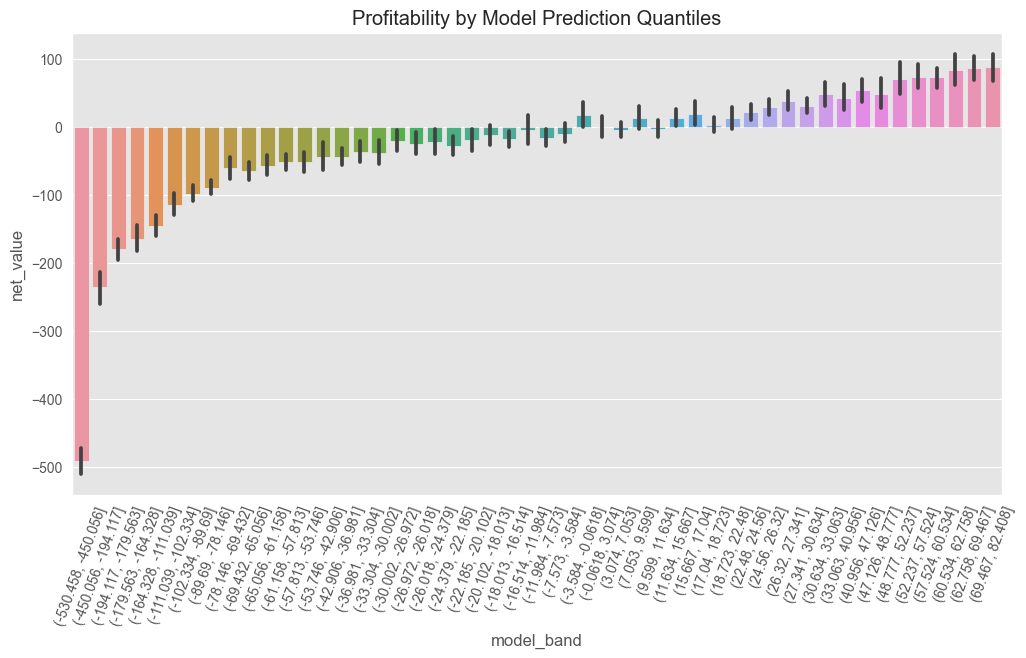

In [12]:
plt.figure(figsize=(12,6))
n_bands = 50
bands = [f"band_{b}" for b in range(1, n_bands+1)]

model_plot = sns.barplot(data=model_policy.assign(model_band = pd.qcut(model_policy["prediction"], q=n_bands)), x="model_band", y="net_value")
plt.title("Profitability by Model Prediction Quantiles")
plt.xticks(rotation=70)

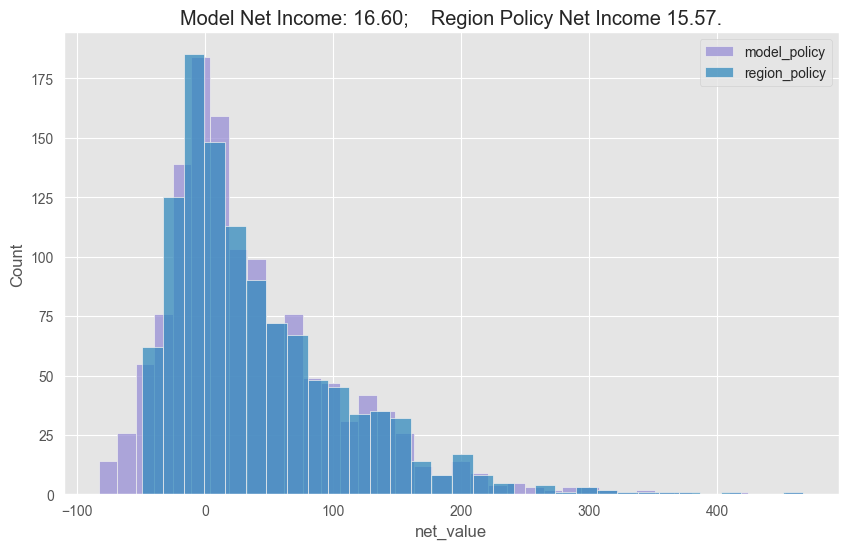

In [13]:
plt.figure(figsize=(10,6))
model_plot_df = (model_policy[model_policy["prediction"]>0])
sns.histplot(data=model_plot_df, x="net_value", color="C2", label="model_policy")
region_plot_df = (model_policy[model_policy["region"].isin(regions_to_invest.keys())])
sns.histplot(data=region_plot_df, x="net_value", label="region_policy")

plt.title("Model Net Income: %.2f; Region Policy Net Income %.2f."%(model_plot_df["net_value"].sum() / test.shape[0],
                                                                    region_plot_df["net_value"].sum() / test.shape[0]))
plt.legend()

## Fine Grain Policy

In [17]:
def model_binner(prediction_column, bins):
    # find the bins according to the training set
    bands = pd.qcut(prediction_column, q=bins, retbins=True)[1]
    def binner_function(prediction_column):
        return np.digitize(prediction_column, bands)
    return binner_function


# train the binning function
binner_fn = model_binner(train_pred["predictions"], 20)

# apply the binning
model_band = model_policy.assign(bands=binner_fn(model_policy["prediction"]))
model_band.head()

,customer_id,region,income,age,net_value,prediction,bands
5952,5952,19,1983,23,21,47.734883,18
1783,1783,31,914,31,-46,-36.026935,7
4811,4811,33,1349,25,-19,22.553420,15
145,145,20,1840,26,55,48.306256,18
7146,7146,19,3032,34,-17,7.039414,13


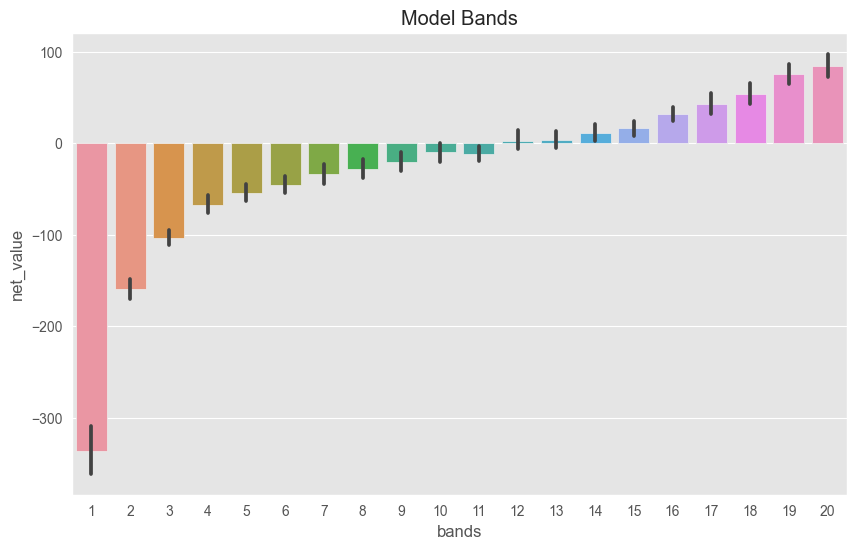

In [18]:
plt.figure(figsize=(10,6))
sns.barplot(data=model_band, x="bands", y="net_value")
plt.title("Model Bands");